# Import Packages

In [1]:
import os
os.environ['XDG_CACHE_HOME'] = 'home/msds2022/mpingol/ .cache'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import string

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import *
from nltk import word_tokenize
from keybert import KeyBERT
from keyphrase_vectorizers import KeyphraseCountVectorizer
from keyphrase_vectorizers import KeyphraseTfidfVectorizer
from sentence_transformers import SentenceTransformer, util
from rouge_score import rouge_scorer

# Load Data

In [3]:
df = pd.ExcelFile('research_profile_v4.xlsx').parse('research_profile')

In [4]:
kp_df = df[['Research Title', 'Abstract', 'Keywords']].copy()
kp_df.columns = ['title', 'abstract', 'keywords']

Note data points with abstracts and keywords for evaluation

In [5]:
stock_idx = kp_df[kp_df['abstract'].notnull()].index & kp_df[kp_df['keywords'].notnull()].index

# Create Corpus

## Pre-process Data

In [6]:
def remove_punctuations(data):
    punct = set(string.punctuation)
    punct.add("’")
    data = ("").join([ch for ch in data if ch not in punct])
    return data

def remove_stopwords(data):
    stop_words = stopwords.words('english')
    data = (" ").join([word for word in data.split() if word not in stop_words])
    return data

def lemma_corpus(data):
    lemmatizer = WordNetLemmatizer()
    data = (" ").join([lemmatizer.lemmatize(word) for word in data.split()])
    return data

def replace_delimiter(data):
    data = re.sub(r"; ", " ", data)
    data = re.sub(r", ", " ", data)
    data = re.sub(r";", " ", data)
    data = re.sub(r",", " ", data)

In [7]:
# process titles
kp_df['title_processed'] = None
for idx in kp_df.index:
    try:
        data = kp_df['title'].loc[idx]
        data = remove_punctuations(data)
        data = remove_stopwords(data)
        data = lemma_corpus(data)
        kp_df['title_processed'].loc[idx] = data
    except:
        continue
        
# process keywords
kp_df['keywords_processed'] = None
for idx in kp_df.index:
    try:
        data = kp_df['keywords'].loc[idx]
        data = replace_delimiter(data)
        data = remove_stopwords(data)
        data = lemma_corpus(data)
        kp_df['keywords_processed'].loc[idx] = data
    except:
        continue
        
# process abstract
kp_df['abstract_processed'] = None
for idx in kp_df.index:
    try:
        data = kp_df['abstract'].loc[idx]
        data = remove_punctuations(data)
        data = remove_stopwords(data)
        data = lemma_corpus(data)
        kp_df['abstract_processed'].loc[idx] = data
    except:
        continue

In [8]:
kp_df['abstract_processed'] = kp_df['abstract_processed'].fillna("")
kp_df['keywords_processed'] = kp_df['keywords_processed'].fillna("")

## Create Corpus

In [9]:
kp_df['corpus'] = None
for idx in kp_df.index:
    try:
        kp_df['corpus'].loc[idx] = (kp_df['title_processed'].loc[idx] + kp_df['keywords_processed'].loc[idx] + kp_df['abstract_processed'].loc[idx])
    except:
        continue

# Run Model

In [10]:
kw_model = KeyBERT('allenai/specter')

In [11]:
corpus = kp_df['corpus'].tolist()
tfidf_vectorizer = KeyphraseTfidfVectorizer()
tfidf_vectorizer.fit_transform(corpus).toarray()

keyphrases1 = kw_model.extract_keywords(docs=corpus, 
                                       vectorizer=tfidf_vectorizer)
keyphrases1 = [(", ").join([phrase[0] for phrase in keyphrase]) for keyphrase in keyphrases1]
kp_df['new_keyphrases'] = np.resize(keyphrases1,len(kp_df))

/home/msds2022/mpingol/.local/lib/python3.9/site-packages/keybert/_model.py:130: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  warnings.warn(
1279it [00:19, 65.39it/s] 


# Evaluation

## Cosine Similarity of Old Keywords to Abstract

In [12]:
model = SentenceTransformer('allenai/specter')
model.max_seq_length = 512

In [13]:
orig_abstract_emb = model.encode(kp_df['abstract'].loc[stock_idx].to_list(), convert_to_tensor=True)
orig_keywords_emb = model.encode(kp_df['keywords'].loc[stock_idx].to_list(), convert_to_tensor=True)

In [14]:
score_df = kp_df.loc[stock_idx].reset_index().copy()
score_df['scores'] = None

for idx in range(len(score_df)):
    score_df['scores'].loc[idx] = (float(util.cos_sim(orig_abstract_emb[idx], orig_keywords_emb[idx])))

/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [15]:
np.mean(score_df['scores'])

0.7005592324583578

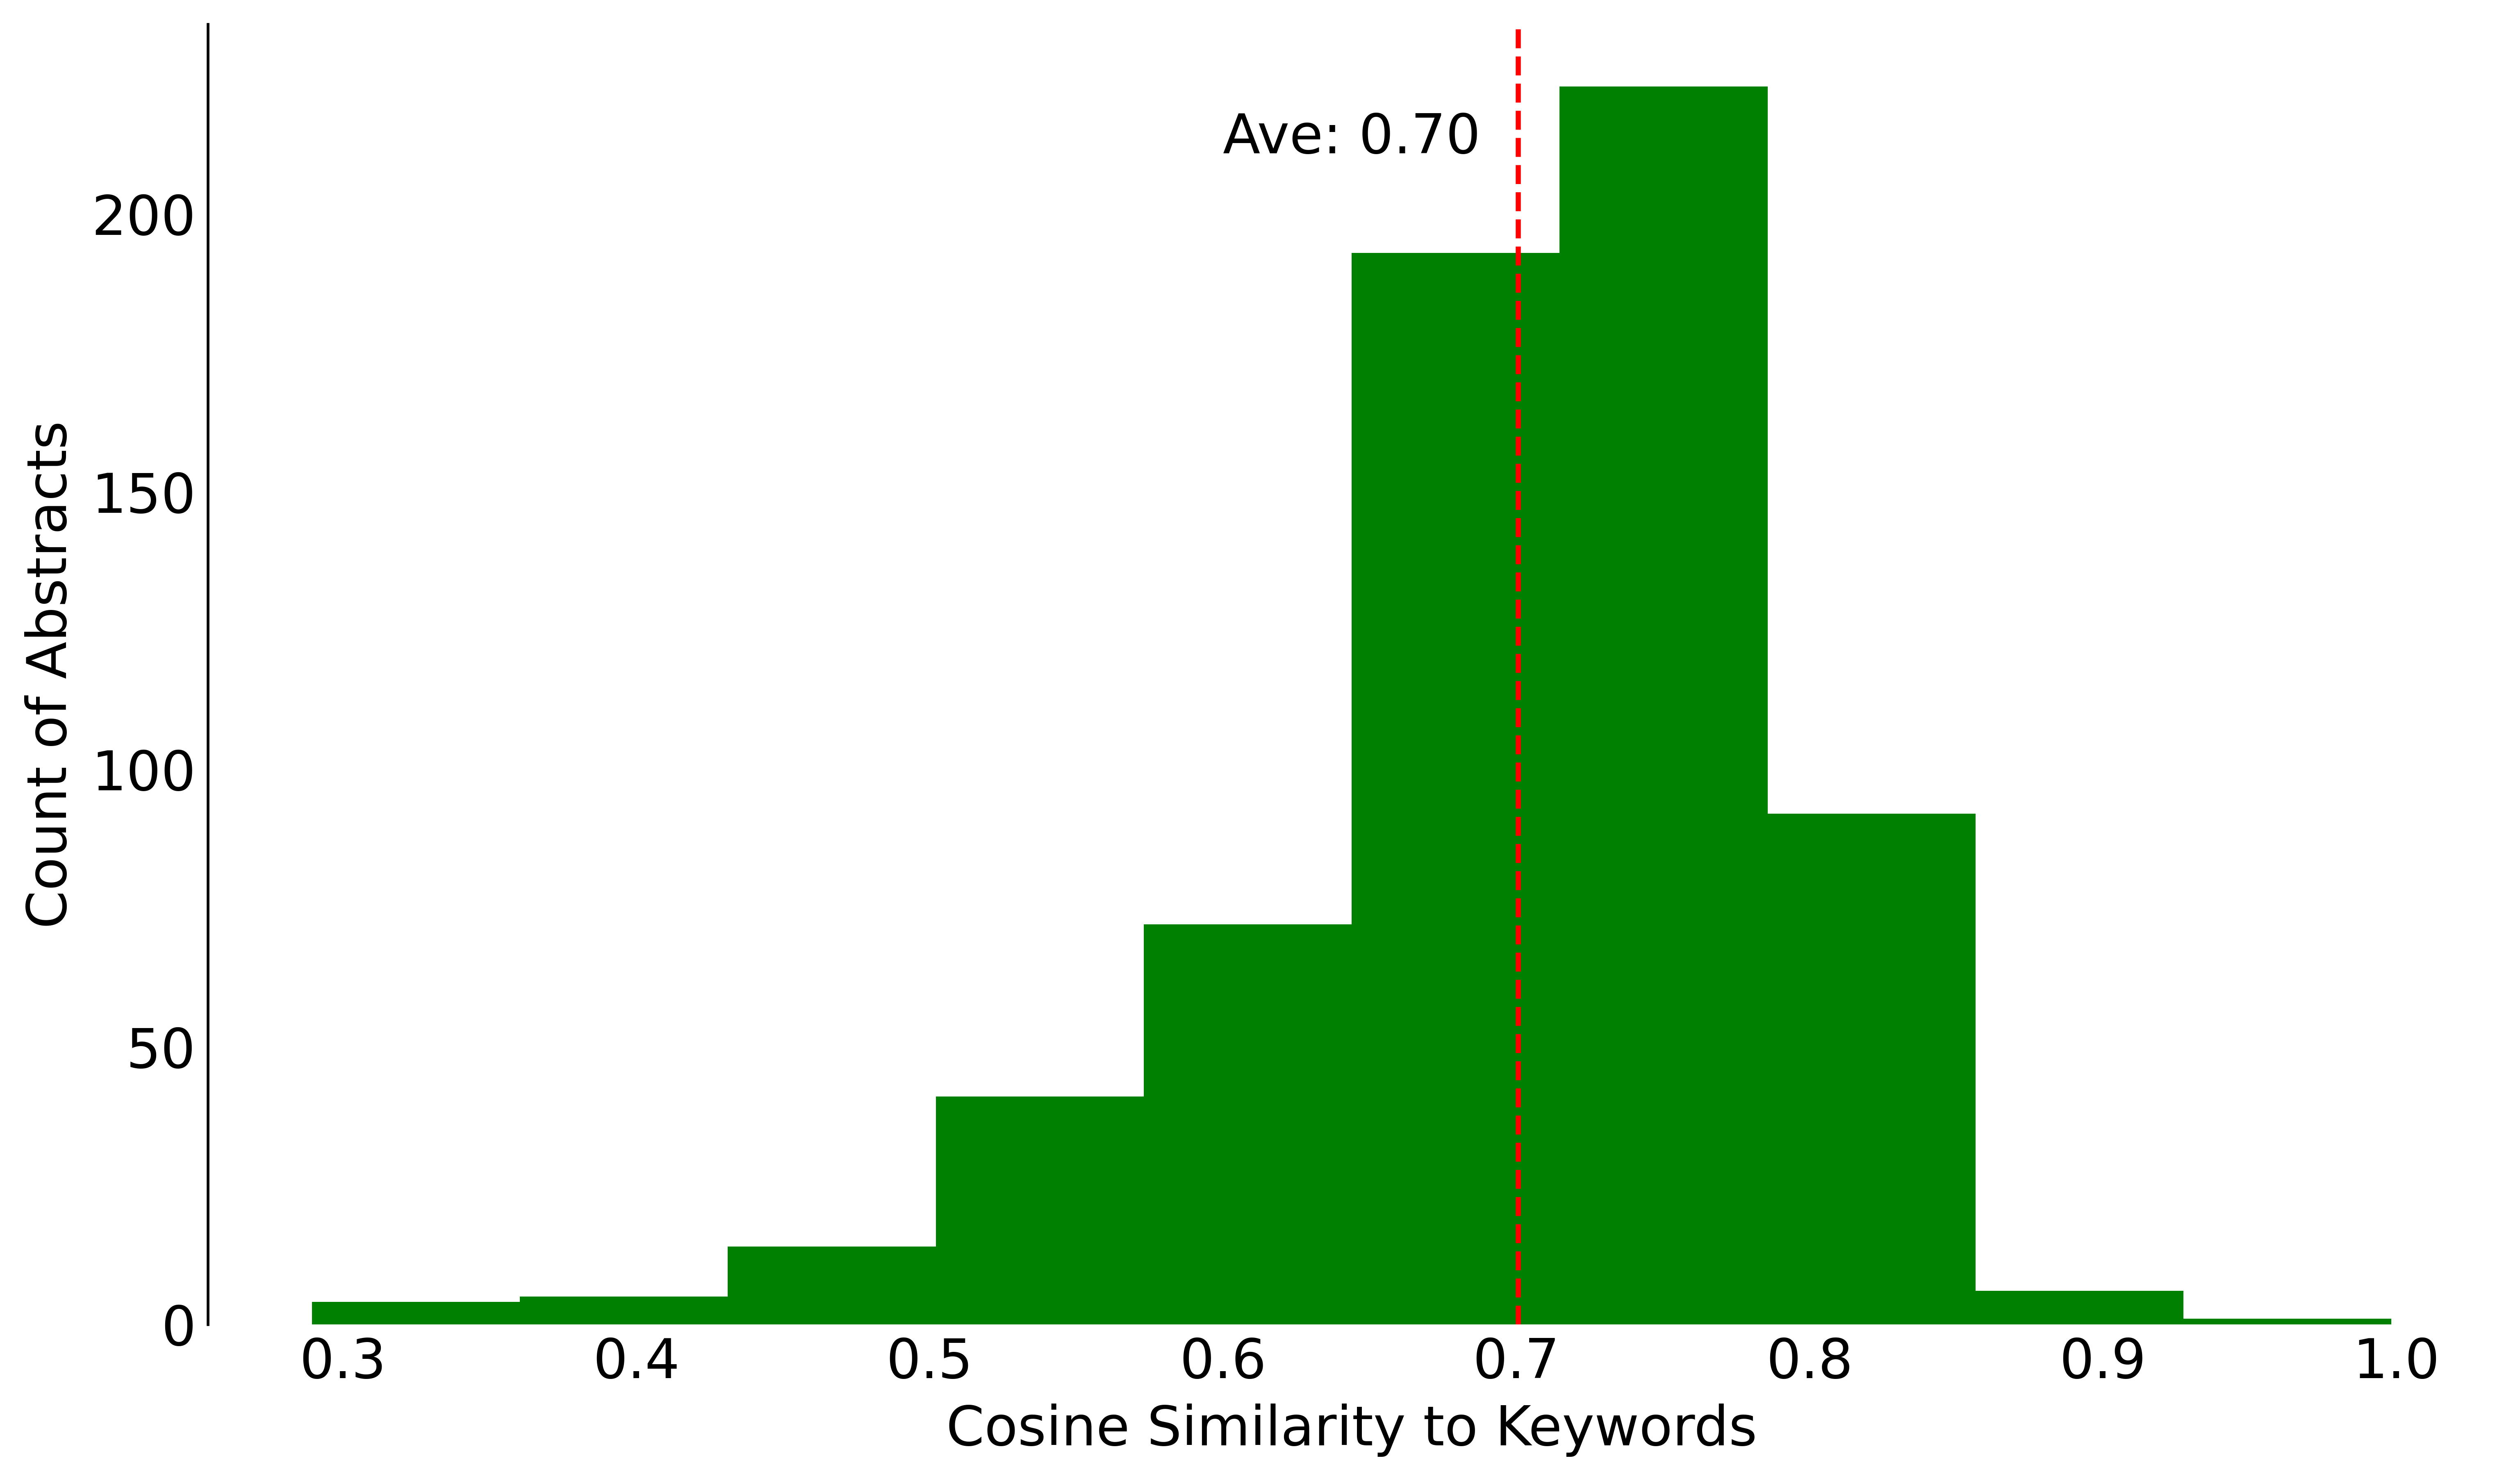

In [16]:
plt.figure(figsize=(12,7), dpi=600)
plt.tick_params(axis='both', which='both', length=0)
plt.gca().spines.right.set_visible(False)
plt.gca().spines.top.set_visible(False)
plt.gca().spines.bottom.set_visible(False)
plt.axvline(np.mean(score_df['scores']), color='red', linestyle='--')
plt.text(.60,211,'Ave: 0.70', fontsize=16)
plt.xlabel('Cosine Similarity to Keywords', fontsize=16)
plt.ylabel('Count of Abstracts', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.hist(score_df['scores'], color='green');

## Cosine Similarity of New Keywords to Abstract

In [17]:
new_keywords_emb = model.encode(kp_df['new_keyphrases'].loc[stock_idx].to_list(), convert_to_tensor=True)

In [18]:
new_scores = []
for idx in range(len(orig_abstract_emb)):
    new_scores.append(float(util.cos_sim(orig_abstract_emb.cpu()[idx], new_keywords_emb.cpu()[idx])))

In [19]:
np.mean(new_scores)

0.8045098069259831

Increased from .70 to .80

## ROGUE Score of Old Keywords to Abstracts

In [25]:
scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)

scores_orig_list = []
scores_new_list = []

for idx in stock_idx:
    
    abstract = kp_df['abstract'].loc[idx]
    orig_kp = kp_df['keywords'].loc[idx]
    new_kp = kp_df['new_keyphrases'].loc[idx]
    
    scores_orig = scorer.score(abstract, orig_kp)
    scores_new = scorer.score(abstract, new_kp)
    
    scores_orig_list.append(scores_orig)
    scores_new_list.append(scores_new)

In [21]:
orig_prec = []
orig_recall = []
orig_fmeasure = []
for i in range(len(scores_orig_list)):
    orig_prec.append(scores_orig_list[i]['rougeL'][0])
    orig_recall.append(scores_orig_list[i]['rougeL'][1])
    orig_fmeasure.append(scores_orig_list[i]['rougeL'][2])

In [22]:
print(np.mean(orig_prec))
print(np.mean(orig_recall))
print(np.mean(orig_fmeasure))

0.6611012392678893
0.03423505109909628
0.062062246013098114


## ROGUE Score of New Keywords to Abstracts

In [23]:
new_prec = []
new_recall = []
new_fmeasure = []
for i in range(len(scores_new_list)):
    new_prec.append(scores_new_list[i]['rougeL'][0])
    new_recall.append(scores_new_list[i]['rougeL'][1])
    new_fmeasure.append(scores_new_list[i]['rougeL'][2])

In [24]:
print(np.mean(new_prec))
print(np.mean(new_recall))
print(np.mean(new_fmeasure))

0.632037525434008
0.0766905007978512
0.12980460628115087


Increased from .06 to .12